# Results Analysis #
--------------------

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import rc
import seaborn as sns
import sys
import os
import warnings

warnings.filterwarnings('ignore')
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts} \usepackage{palatino} \usepackage{mathpazo}')
rc('font',**{'family':'serif','serif':['Palatino'], 'size': 11})
CSV_PATH = "./data/P4_N4096000_BEST/"
FW_PATH = "./data/framework_comparison/"
POL_PATH = "./data/policy_comparison/"
GLOB_PATH = "./data/global_queue/"
IN_PATH = "./data/input_comparison/"

In [172]:
files = os.listdir(CSV_PATH)
forks = pd.concat([pd.read_csv(os.path.join(CSV_PATH, f)) for f in files if f.startswith("S0") and f.endswith(".csv")])
joins = pd.concat([pd.read_csv(os.path.join(CSV_PATH, f)) for f in files if f.startswith("S1") and f.endswith(".csv")])
forks = forks.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })
joins = joins.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })

display(forks.head(20))
display(joins.head(20))

,Time (ms),ID,Code,info1,info2
0,35.6823,0,CREATE,0.00000,0.00000
0,35.7309,1,CREATE,0.00000,1.00000
0,35.7668,2,CREATE,0.00000,2.00000
0,35.7936,3,CREATE,0.00000,3.00000
1,35.9184,0,SC_BGN,NaN,NaN
2,35.9252,0,CHI_NO,16.33330,1.33333
3,35.9331,0,SC_GLB,NaN,NaN
1,36.0153,3,RT_BGN,NaN,NaN
2,36.0253,3,RT_GLB,NaN,NaN
1,36.0302,2,RT_BGN,NaN,NaN


,Time (ms),ID,Code,info1,info2
0,35.8221,0,CREATE,1.0,0.0
0,35.8481,1,CREATE,1.0,1.0
0,35.8781,2,CREATE,1.0,2.0
0,35.9099,3,CREATE,1.0,3.0
1,36.0339,3,SC_BGN,NaN,NaN
2,36.0399,3,SC_LOC,NaN,NaN
3,36.0844,3,SC_BGN,NaN,NaN
4,36.0899,3,SC_LOC,NaN,NaN
5,36.1074,3,SC_BGN,NaN,NaN
6,36.1112,3,SC_LOC,NaN,NaN


## Queue Dimensions ##

In [173]:
n_ws = len(forks.ID.unique())
loc_hs = np.zeros((n_ws, len(forks)))
glob_h = np.zeros(len(forks))

last_l = np.zeros(n_ws)
last_g = 0

for i, (t, wid, code, i1, i2) in enumerate(forks.itertuples(index=False, name=None)):
    if code == "SC_LOC":
        last_l[wid] += 1
    elif code == "RT_LOC":
        last_l[wid] -= 1
    elif code == "SC_GLB":
        last_g += 1
    elif code == "RT_GLB":
        last_g -= 1
    
    loc_hs[:, i] = last_l
    glob_h[i] = last_g

In [174]:
dfs = []

for i in range(n_ws):
    local = forks[['Time (ms)']].copy()
    local['Size'] = loc_hs[i, :]
    local['Queue'] = "$Q_{}$".format(i)
    dfs.append(local)

glob = forks[['Time (ms)']].copy()
glob['Size'] = glob_h
glob['Queue'] = "Global"
dfs.append(glob)

queues = pd.concat(dfs).sort_values('Time (ms)')
queues[['Size', 'Queue']].groupby('Queue').describe()

Size                                             
         count      mean       std  min  25%  50%  75%  max
Queue                                                      
$Q_0$   6156.0  3.719298  1.492845  0.0  3.0  4.0  5.0  8.0
$Q_1$   6156.0  3.851527  1.590503  0.0  3.0  4.0  5.0  9.0
$Q_2$   6156.0  2.715400  1.406460  0.0  2.0  3.0  4.0  7.0
$Q_3$   6156.0  3.050682  1.525850  0.0  2.0  3.0  4.0  8.0
Global  6156.0  1.164717  0.748568  0.0  1.0  1.0  2.0  2.0

In [175]:
fig, axes = plt.subplots(n_ws + 3, 1, figsize=(10, 9), sharex=True)
max_size = queues['Size'].max()

for i, q in enumerate(sorted(queues.Queue.unique())):
    queues[queues.Queue == q].plot(x='Time (ms)', y='Size', color='k', lw=1., ax=axes[i])
    axes[i].set_ylim((-0.25, max_size + 0.25))
    axes[i].set_ylabel(q)
    axes[i].legend().remove()

chis = forks[forks.Code.apply(lambda c: c.startswith('CHI_'))].copy()
chis['info1'] = chis.apply(lambda r: 0. if r['Code'] == 'CHI_SK' else r['info1'], axis=1)

axes[n_ws+1].axhline(4./3., linestyle=':', linewidth=1., c='gray')

sns.lineplot(data=chis, x='Time (ms)', y='info1', style='ID', color='k', lw=1., ax=axes[n_ws+1])

for t, i, _, chi, _ in chis[chis.info1 >= 4./3.].itertuples(index=False, name=False):
    axes[n_ws+1].annotate(i, (t+0.2, chi+0.1))
    
axes[n_ws+1].set_ylabel(r'$\chi^2_w$')
axes[n_ws+1].set_xlabel('Time $(ms)$')
axes[n_ws+1].get_legend().remove()
# axes[n_ws+1].set_yscale('log')
axes[n_ws+1].set_ylim((-0.05, 4.5))

(-0.05, 4.5)

## Waiting Time ##

In [176]:
n_ws = len(forks.ID.unique())
rt_wait = [[],[],[],[]] 
sc_wait = [[],[],[],[]] 

from_t = np.zeros(n_ws)

for i, (t, wid, code, i1, i2) in enumerate(forks.itertuples(index=False, name=None)):
    if code == "SC_GLB":
        sc_wait[wid].append([from_t[wid], t])
    elif code == "RT_GLB":
        rt_wait[wid].append([from_t[wid], t])
    elif code == "SC_BGN" or code == "RT_BGN":
        from_t[wid] = t

display(rt_wait)
display(sc_wait)

[[[36.0303, 36.1215], [83.0348, 83.0402]],
 [[36.0303, 36.1006]],
 [[36.0302, 36.1444],
  [61.9992, 62.0056],
  [68.3603, 68.3662],
  [74.7189, 74.7249],
  [77.9602, 77.9662],
  [81.1159, 81.5148]],
 [[36.0153, 36.0253],
  [51.9097, 51.9139],
  [66.78, 66.7842],
  [76.4115, 76.4159],
  [81.4797, 81.5397]]]

[[[35.9184, 35.9331], [81.4861, 81.5029], [81.5194, 81.5317]],
 [[41.4002, 41.4144], [81.487, 81.5103]],
 [[74.8603, 74.874], [74.891, 74.903]],
 [[36.0452, 36.0635],
  [36.0938, 36.1028],
  [36.1157, 36.1277],
  [49.4696, 49.479],
  [52.7004, 52.7129],
  [62.1019, 62.111000000000004],
  [68.1253, 68.134]]]

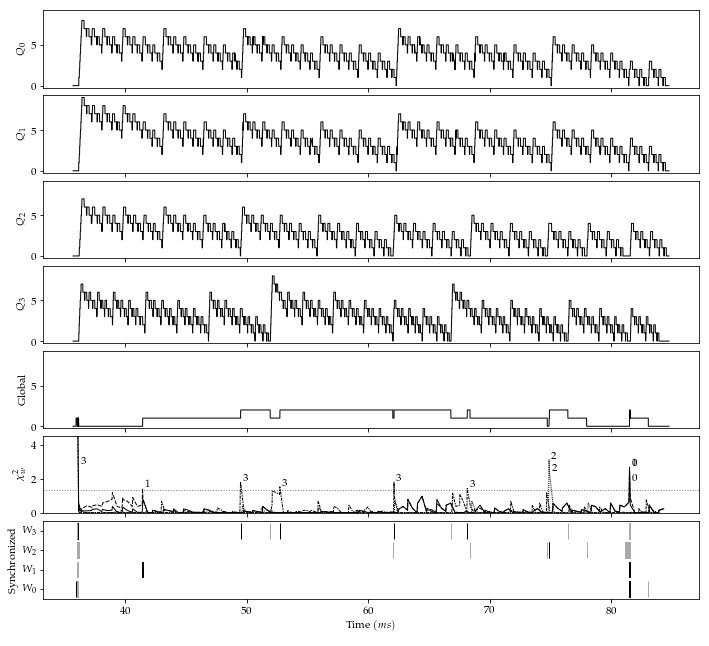

In [177]:
types = ['Schedule', 'Retrieve']

for t in types:
    c = 'darkgray' if t != "Schedule" else 'k'    
    arr = sc_wait if t == "Schedule" else rt_wait
    
    rects = []
    for i in range(4):
        for from_t, to_t in reversed(arr[i]):
            rects.append(Rectangle((from_t, i - 0.4), to_t - from_t, 0.8))
                
    pc = PatchCollection(rects, facecolor=c, edgecolor=c)
    axes[n_ws+2].add_collection(pc)

axes[n_ws+2].set_xlabel("Time $(ms)$")
axes[n_ws+2].set_ylabel("Synchronized")
axes[n_ws+2].set_yticks([0, 1, 2, 3])
axes[n_ws+2].set_ylim((-0.5, 3.5))
axes[n_ws+2].set_yticklabels(["$W_0$", "$W_1$", "$W_2$", "$W_3$" ])

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("../report/figures/queues.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Startup ##

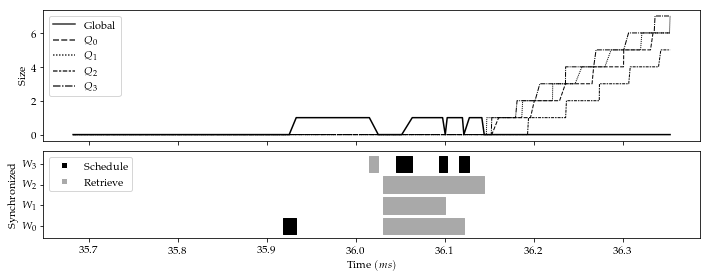

In [178]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

limit = 500
max_t = queues[:limit]['Time (ms)'].max()
legend_elements = []

sns.lineplot(data=queues[:limit], x='Time (ms)', y='Size', color='k', style='Queue', style_order=['Global'] + sorted(queues.Queue.unique())[:-1],
             size=queues[:limit].Queue.apply(lambda q: 2 if q == 'Global' else 1), sizes=(1, 1.5), legend='brief', ax=axes[0])

types = ['Schedule', 'Retrieve']

for t in types:
    c = 'darkgray' if t != "Schedule" else 'k'
    legend_elements.append(Line2D([0], [0], color='w', marker='s', markerfacecolor=c, label=t))
    
    arr = sc_wait if t == "Schedule" else rt_wait
    
    rects = []
    for i in range(4):
        for from_t, to_t in reversed(arr[i]):
            if to_t <= max_t:
                rects.append(Rectangle((from_t, i - 0.4), to_t - from_t, 0.8))
                
    pc = PatchCollection(rects, facecolor=c, edgecolor=c)
    axes[1].add_collection(pc)

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[4:], labels[4:])

axes[1].legend(legend_elements, types, loc='upper left')

axes[1].set_ylabel("Synchronized")
axes[1].set_yticks([0, 1, 2, 3 ])
axes[1].set_ylim((-0.6, 3.6))
axes[1].set_yticklabels(["$W_0$", "$W_1$", "$W_2$", "$W_3$" ])
axes[1].set_xlabel("Time $(ms)$")

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("../report/figures/startup.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Preformances ##

### Policy Comparison ###

In [73]:
dfs = []
files = [ f for f in os.listdir(POL_PATH) if f.endswith('.csv')]

for f in files:
    df = pd.read_csv(os.path.join(POL_PATH, f))
    policy = os.path.splitext(f)[0]
    df['Policy'] = policy if policy != "only_global" else "only\_global"
    dfs.append(df)

sp = pd.concat(dfs)
sp['Time $(s)$'] = sp['Time (ms)'] / 1000.
sp.head()

,Workers,Time (ms),Policy,Time $(s)$
0,1,2445395,best,2445.395
1,1,2401806,best,2401.806
2,1,2408005,best,2408.005
3,1,2394306,best,2394.306
4,1,2403247,best,2403.247


In [74]:
avg = sp[sp.Workers == 1].groupby('Policy')['Time (ms)'].mean()

sp['Scalability'] = avg[sp.Policy].values / sp['Time (ms)'].values
sp.groupby(['Workers', 'Policy']).describe()

Scalability                                          \
                           count      mean       std       min       25%   
Workers Policy                                                             
1       best                 5.0  1.000055  0.008256  0.985752  1.001058   
        only\_global         5.0  1.000086  0.010311  0.981731  1.003678   
        relaxed              5.0  1.000132  0.012761  0.979100  0.997407   
        strict               5.0  1.000113  0.011781  0.979613  1.000525   
        strong               5.0  1.000101  0.011132  0.980513  1.002014   
2       best                 5.0  1.840553  0.018046  1.809914  1.839255   
        only\_global         5.0  1.758547  0.025432  1.714889  1.758960   
        relaxed              5.0  1.853083  0.013349  1.829930  1.853405   
        strict               5.0  1.848553  0.007202  1.835865  1.850028   
        strong               5.0  1.828479  0.013864  1.812529  1.821472   
4       best                 5.0  3.197625  0.098637  3.048927  3.152519   
        only\_global         5.0  3.138679  0.087025  3.007527  3.115770   
        relaxed              5.0  3.218564  0.154459  2.973643  3.217627   
        strict               5.0  3.171133  0.037851  3.137723  3.139394   
        strong               5.0  3.180757  0.078213  3.067049  3.142457   
8       best                 5.0  5.019445  0.181691  4.763362  4.994741   
        only\_global         5.0  4.677840  0.225995  4.317124  4.616393   
        relaxed              5.0  4.890033  0.118517  4.762231  4.773889   
        strict               5.0  4.993955  0.081047  4.938161  4.950287   
        strong               5.0  5.057919  0.182120  4.785856  4.961464   
16      best                 5.0  7.289460  0.094109  7.204021  7.211348   
        only\_global         5.0  6.308464  0.238345  5.998986  6.159853   
        relaxed              5.0  6.801003  0.178153  6.598170  6.655981   
        strict               5.0  7.047641  0.485605  6.498505  6.536690   
        strong               5.0  7.112666  0.280734  6.719091  7.066835   
32      best                 5.0  8.313552  0.334191  7.900288  8.118660   
        only\_global         5.0  7.238815  0.326290  6.866831  7.094483   
        relaxed              5.0  8.496000  0.532016  7.555976  8.651187   
        strict               5.0  8.357657  0.410955  7.929880  8.096458   
        strong               5.0  8.027158  0.700039  7.094403  7.465763   
64      best                 5.0  8.924475  0.585775  8.389226  8.547965   
        only\_global         5.0  7.296149  0.343984  6.793300  7.159850   
        relaxed              5.0  9.012507  0.525182  8.429236  8.489915   
        strict               5.0  8.824768  0.559007  8.216503  8.305111   
        strong               5.0  8.361003  0.322566  7.907321  8.275276   
128     best                 5.0  8.070175  0.416523  7.492422  7.825197   
        only\_global         5.0  6.582415  0.321094  6.175841  6.377354   
        relaxed              5.0  8.695239  0.721658  7.467907  8.684361   
        strict               5.0  8.070504  0.395959  7.401877  8.013265   
        strong               5.0  7.632179  0.255568  7.266545  7.488430   
256     best                 5.0  7.172140  0.552408  6.393223  6.868726   
        only\_global         5.0  4.946602  0.303244  4.738048  4.776145   
        relaxed              5.0  7.854352  0.255801  7.499131  7.781298   
        strict               5.0  7.166177  0.337204  6.595035  7.168379   
        strong               5.0  7.026595  0.452245  6.231523  7.088521   

                                                   Time $(s)$             \
                           50%       75%       max      count       mean   
Workers Policy                                                             
1       best          1.003040  1.003641  1.006785        5.0  2410.5518   
        only\_global  1.003728  1.005227  1.006066        5.0  2415.

RuntimeError: latex was not able to process the following string:
b'\\tt\\x08fseries best'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/flandolfi/.cache/matplotlib/tex.cache/ed01d7f1d60cb8245fa508a8159e4932.t
ex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 10 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathpazo.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amsfonts.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/palatino.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./ed01d7f1d60cb8245fa508a8159e4932.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Text line contains an invalid character.
l.13 ...size{11.000000}{13.750000}{\rmfamily 	t^^H
                                                  fseries best}
No pages of output.
Transcript written on ed01d7f1d60cb8245fa508a8159e4932.log.




<Figure size 720x216 with 2 Axes>

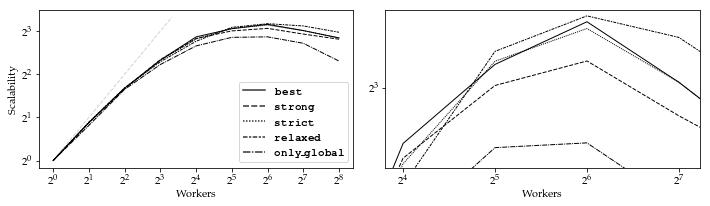

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [2, 2]})

ideal = [i for i in range(1, 11)]
axes[0].plot(ideal, ideal, ls='--', c='lightgray', lw=1)

sns.lineplot(data=sp, x='Workers', y='Scalability', style='Policy', 
             style_order=['best', 'strong', 'strict', 'relaxed', 'only\_global'], 
             ci=None, color='k', ax=axes[0], lw=1)
sns.lineplot(data=sp, x='Workers', y='Scalability', style='Policy', 
             style_order=['best', 'strong', 'strict', 'relaxed', 'only\_global'], 
             ci=None, color='k', ax=axes[1], lw=1)

axes[0].set_xscale('log', basex=2)
axes[0].set_yscale('log', basey=2)

axes[1].set_xlim((14, 150))
axes[1].set_ylim((7, 9.1))
axes[1].set_xscale('log', basex=2)
axes[1].set_yscale('log', basey=2)
axes[1].legend().remove()
axes[1].set_ylabel("")

handles, labels = axes[0].get_legend_handles_labels()
labels = [r"\tt\bfseries %s" % l for l in labels[1:]]
axes[0].legend(handles[1:], labels)

plt.tight_layout()
# plt.subplots_adjust(wspace=0.1)
plt.savefig("../report/figures/policy_comparison.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Framework Comparison ###

In [113]:
dfs = []
dirs = [ f for f in os.listdir(IN_PATH) if os.path.isdir(os.path.join(IN_PATH, f))]
files = [ f for f in os.listdir(IN_PATH) if f.endswith('.csv')]

for alg in ['Mergesort', 'Quicksort']:
    dirs = [ f for f in os.listdir(os.path.join(IN_PATH, alg.lower())) if os.path.isdir(os.path.join(IN_PATH, alg.lower(), f))]
    
    for d in dirs:
        files = [ f for f in os.listdir(os.path.join(IN_PATH, alg.lower(), d)) if f.endswith('.csv')]

        for f in files:
            df = pd.read_csv(os.path.join(IN_PATH, alg.lower(), d, f))
            df['Framework'] = os.path.splitext(f)[0].upper()
            df['Input Size'] = d
            df['Algorithm'] = alg
            dfs.append(df)

si = pd.concat(dfs)
si['Time $(s)$'] = si['Time (ms)'] / 1000.
si['Input Size'] = si['Input Size'].apply(int)
si.head()

,Workers,Time (ms),Framework,Input Size,Algorithm,Time $(s)$
0,1,2406484,OMP,10000000,Mergesort,2406.484
1,1,2357665,OMP,10000000,Mergesort,2357.665
2,1,2367247,OMP,10000000,Mergesort,2367.247
3,1,2367635,OMP,10000000,Mergesort,2367.635
4,1,2356734,OMP,10000000,Mergesort,2356.734


In [114]:
avg = si[si.Workers == 1].groupby(['Algorithm', 'Framework', 'Input Size'])['Time (ms)'].mean()
si['Scalability'] = avg[si[['Algorithm', 'Framework', 'Input Size']].values].values / si['Time (ms)'].values

si.groupby(['Algorithm', 'Workers', 'Input Size', 'Framework']).describe()

Scalability                      \
                                             count      mean       std   
Algorithm Workers Input Size Framework                                   
Mergesort 1       10000000   DAC               5.0  1.000055  0.008256   
                             FF                5.0  1.000132  0.012745   
                             OMP               5.0  1.000059  0.008524   
                             TBB               5.0  1.000050  0.007851   
                  20000000   DAC               5.0  1.000034  0.006535   
                             FF                5.0  1.000021  0.005123   
                             OMP               5.0  1.000011  0.003656   
                             TBB               5.0  1.000009  0.003420   
                  50000000   DAC               5.0  1.000006  0.002725   
                             FF                5.0  1.000008  0.003223   
                             OMP               5.0  1.000003  0.001921   
                             TBB               5.0  1.000003  0.001927   
                  100000000  DAC               5.0  1.000006  0.002796   
                             FF                5.0  1.000001  0.001323   
                             OMP               5.0  1.000001  0.001227   
                             TBB               5.0  1.000001  0.001143   
          2       10000000   DAC               5.0  1.840553  0.018046   
                             FF                5.0  1.779637  0.017021   
                             OMP               5.0  1.851896  0.007869   
                             TBB               5.0  1.858973  0.006765   
                  20000000   DAC               5.0  1.840964  0.011417   
                             FF                5.0  1.792101  0.024095   
                             OMP               5.0  1.856108  0.003659   
                             TBB               5.0  1.852654  0.002257   
                  50000000   DAC               5.0  1.847495  0.005243   
                             FF                5.0  1.806171  0.031754   
                             OMP               5.0  1.853009  0.000819   
                             TBB               5.0  1.863164  0.001081   
                  100000000  DAC               5.0  1.854002  0.009368   
                             FF                5.0  1.796974  0.011730   
...                                            ...       ...       ...   
Quicksort 128     10000000   OMP               5.0  4.418809  0.217272   
                             TBB               5.0  5.165769  0.633122   
                  20000000   DAC               5.0  5.486050  0.404253   
                             FF                5.0  3.050991  0.150931   
                             OMP               5.0  4.645160  0.373099   
                             TBB               5.0  5.363061  0.640503   
                  50000000   DAC               5.0  5.348256  0.533799   
                             FF                5.0  3.116044  0.107538   
                             OMP               5.0  5.203139  0.109611   
                             TBB               5.0  5.493644  0.641137   
                  100000000  DAC               5.0  6.303903  0.467164   
                             FF                5.0  3.131774  0.103846   
                             OMP               5.0  4.964808  0.302812   
                             TBB               5.0  5.822976  0.445193   
          256     10000000   DAC               5.0  4.239476  0.379783   
                             FF                5.0  1.128908  0.086633   
                             OMP               5.0  2.716666  0.114656   
                             TBB               5.0  4.815910  0.935735   
                  20000000   DAC               5.0  4.775785  0.403827   
                             FF                5.0  1.166745  0.086686   
                             OMP           

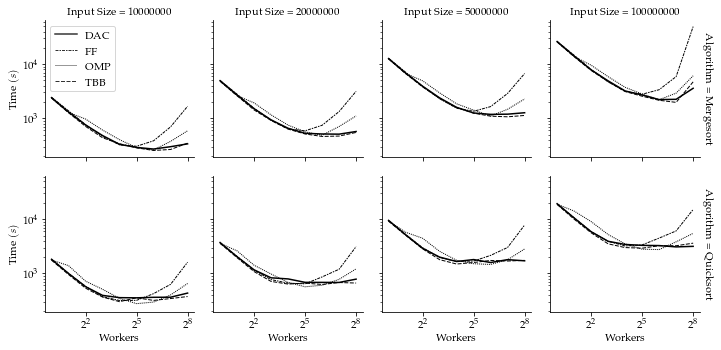

In [162]:
g = sns.FacetGrid(si, 
                  col='Input Size', row='Algorithm',
                  sharex=True, sharey=True, 
                  height=2.5, aspect=1.,
                  margin_titles=True)
g = g.map_dataframe(sns.lineplot, 'Workers', 'Time $(s)$', style='Framework', 
                    style_order=['DAC', 'TBB', 'OMP', 'FF'], color='k', ci=None,
                    size='Framework', sizes={
                        'DAC':1.5,
                        'TBB':1, 
                        'OMP':1, 
                        'FF':1
                    })

for row in g.axes:
    for ax in row:
        ax.set_xscale('log', basex=2)
        ax.set_yscale('log', basey=10)

handles, labels = g.axes[0, 0].get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels[1:], handles[1:])))
g.axes[0, 0].legend(handles, labels, loc='upper left')

plt.tight_layout()
plt.savefig("../report/figures/time_input.pdf", format='pdf', bbox_inches='tight')
plt.show()

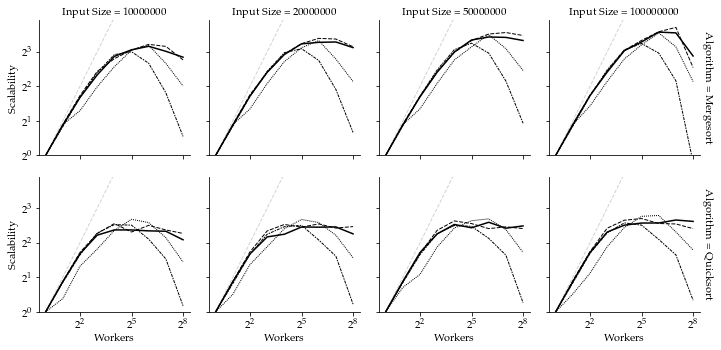

In [163]:
g = sns.FacetGrid(si, 
                  col='Input Size', row='Algorithm',
                  sharex=True, sharey=True, 
                  height=2.5, aspect=1.,
                  margin_titles=True)

for row in g.axes:
    for ax in row:
        ax.plot(2**np.arange(9), 2**np.arange(9), ls='--', lw=1, c='lightgray')
        ax.set_xscale('log', basex=2)
        ax.set_yscale('log', basey=2)
        ax.set_ylim((1, 15))

g = g.map_dataframe(sns.lineplot, 'Workers', 'Scalability', style='Framework', 
                    style_order=['DAC', 'TBB', 'OMP', 'FF'], color='k', ci=None,
                    size='Framework', sizes={
                        'DAC':1.5,
                        'TBB':1, 
                        'OMP':1, 
                        'FF':1
                    })


plt.tight_layout()
plt.savefig("../report/figures/scalability_input.pdf", format='pdf', bbox_inches='tight')
plt.show()

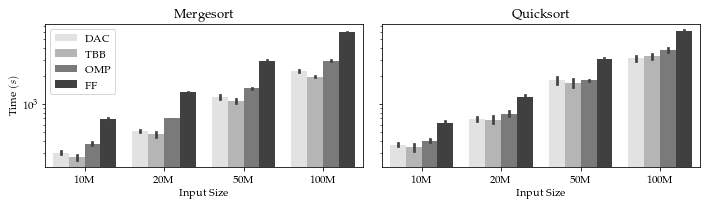

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ws = 128

sns.barplot(data=si[(si.Workers == ws) & (si.Algorithm == 'Mergesort')], x='Input Size', y='Time $(s)$', hue='Framework', 
            hue_order=['DAC', 'TBB', 'OMP', 'FF'], ax=axes[0], palette=sns.color_palette('Greys', 4), saturation=1)
sns.barplot(data=si[(si.Workers == ws) & (si.Algorithm == 'Quicksort')], x='Input Size', y='Time $(s)$', hue='Framework',
            hue_order=['DAC', 'TBB', 'OMP', 'FF'], ax=axes[1], palette=sns.color_palette('Greys', 4), saturation=1)

axes[0].set_title('Mergesort')
axes[1].set_title('Quicksort')
axes[0].set_xticklabels(['10M', '20M', '50M', '100M'])
axes[1].set_xticklabels(['10M', '20M', '50M', '100M'])
axes[1].set_ylabel("")
axes[0].set_yscale("log")
axes[1].legend().remove()

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='upper left')

plt.tight_layout()
plt.savefig("../report/figures/time_input_{}.pdf".format(ws), format='pdf', bbox_inches='tight')
plt.show()